Importing Libraries

In [50]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Energy Data

In [51]:
# Combining all blocks
# for num in range(0,112):
#     df = pd.read_csv("C:/Users/diana/Desktop/proiect test/daily_dataset/block_"+str(num)+".csv")
#     df = df[['day','LCLid','energy_sum']]
#     df.reset_index()
#     df.to_csv("hc_"+str(num)+".csv")

# fout= open("energy.csv","a")
# # first file:
# for line in open("hc_0.csv"):
#     fout.write(line)
# # now the rest:    
# for num in range(0,112):
#     f = open("hc_"+str(num)+".csv")
#     f.readline() # skip the header
#     for line in f:
#          fout.write(line)
#     f.close()
# fout.close()

Energy data at day level

In [52]:
energy = pd.read_csv('energy.csv')
len(energy)

3536007

Counting the households

In [53]:
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(4)

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41


<Axes: xlabel='day'>

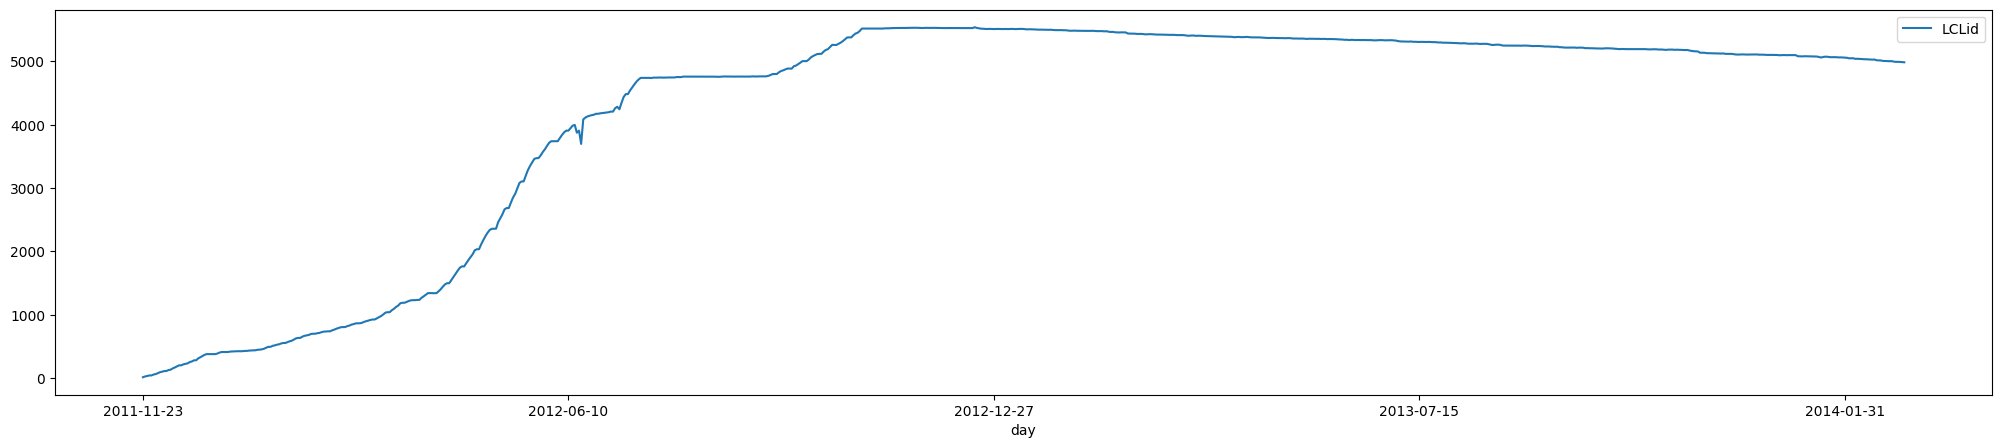

In [54]:
housecount.plot(figsize=(25,5))

Normalization across households

In [55]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [56]:
energy.count()

day           829
energy_sum    829
LCLid         829
dtype: int64

In [57]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [58]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [59]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436002,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


Weather Information

In [60]:
weather = pd.read_csv("C:/Users/diana/Desktop/proiect test/weather_daily_darksky.csv")
weather.head(4)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25


In [61]:
weather.describe()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


In [62]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

Relationship of weather conditions with electricity consumption

In [63]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97


1. Temperature

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


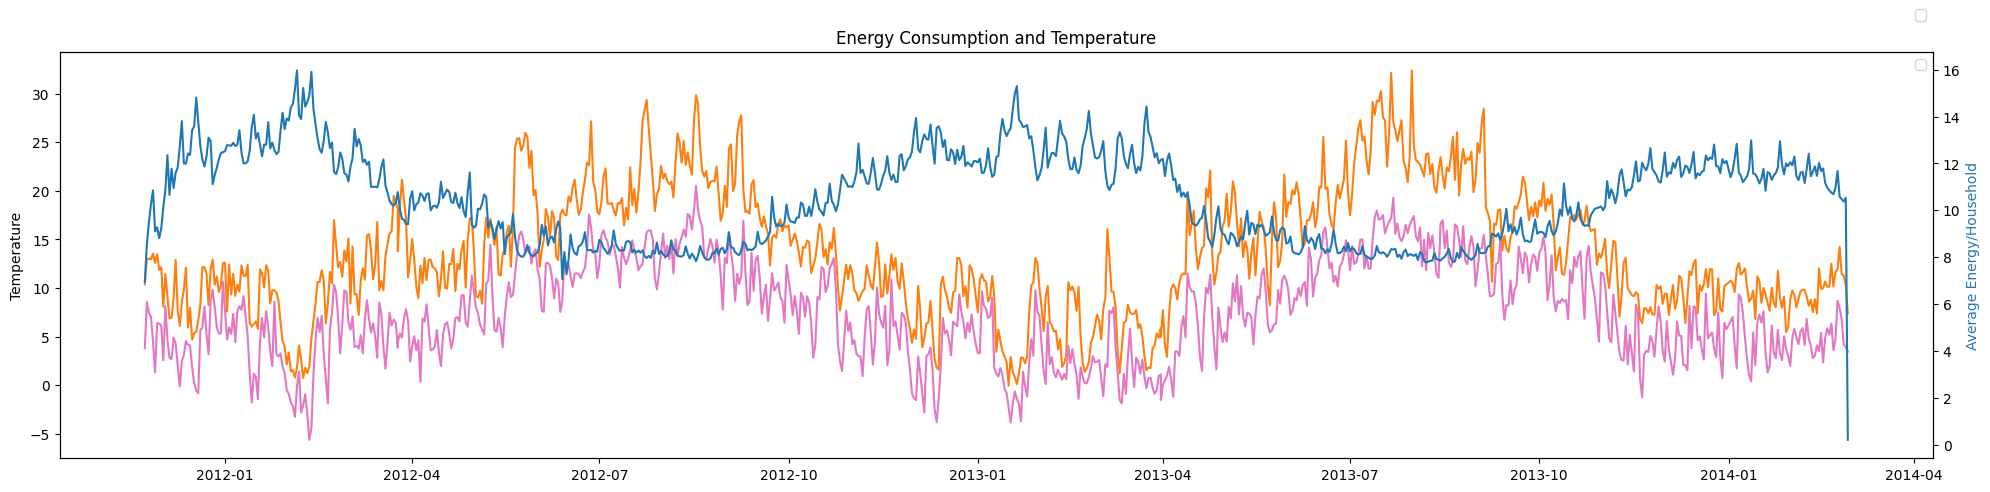

In [64]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

2. Humidity

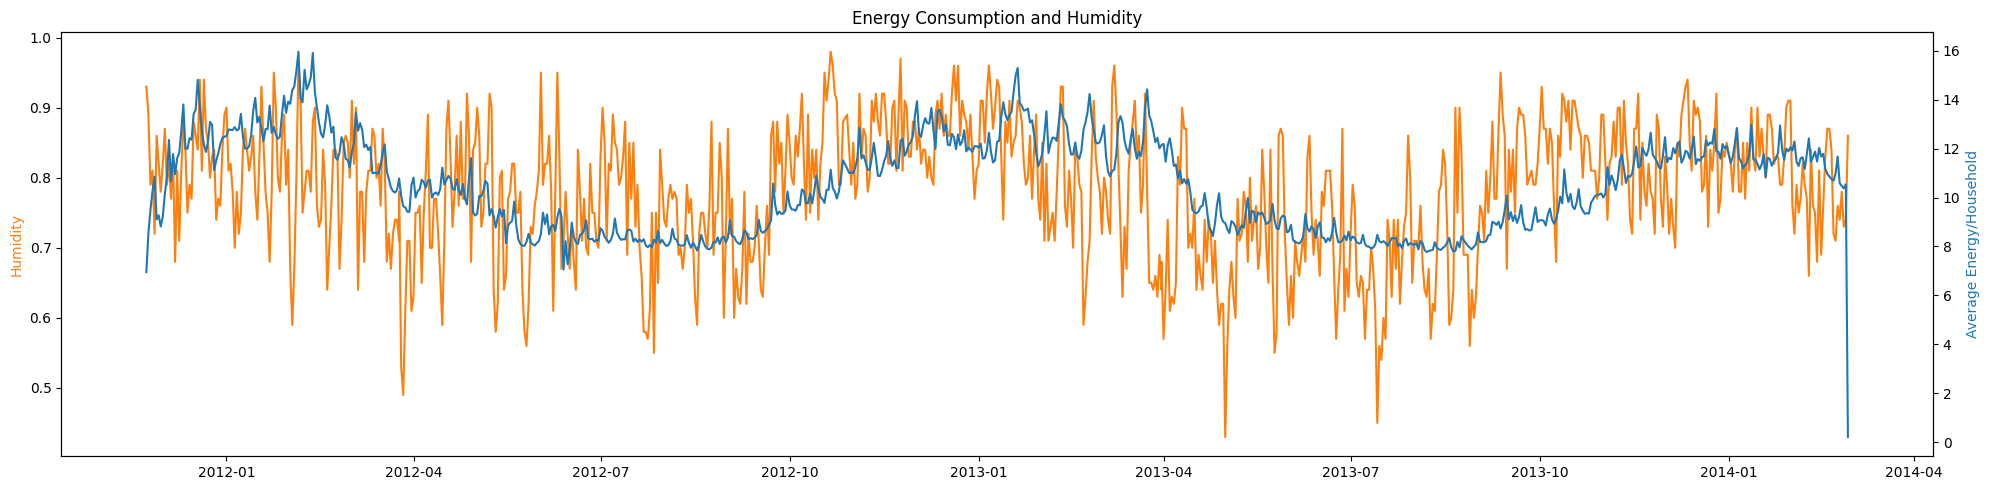

In [65]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

3. Cloud Cover

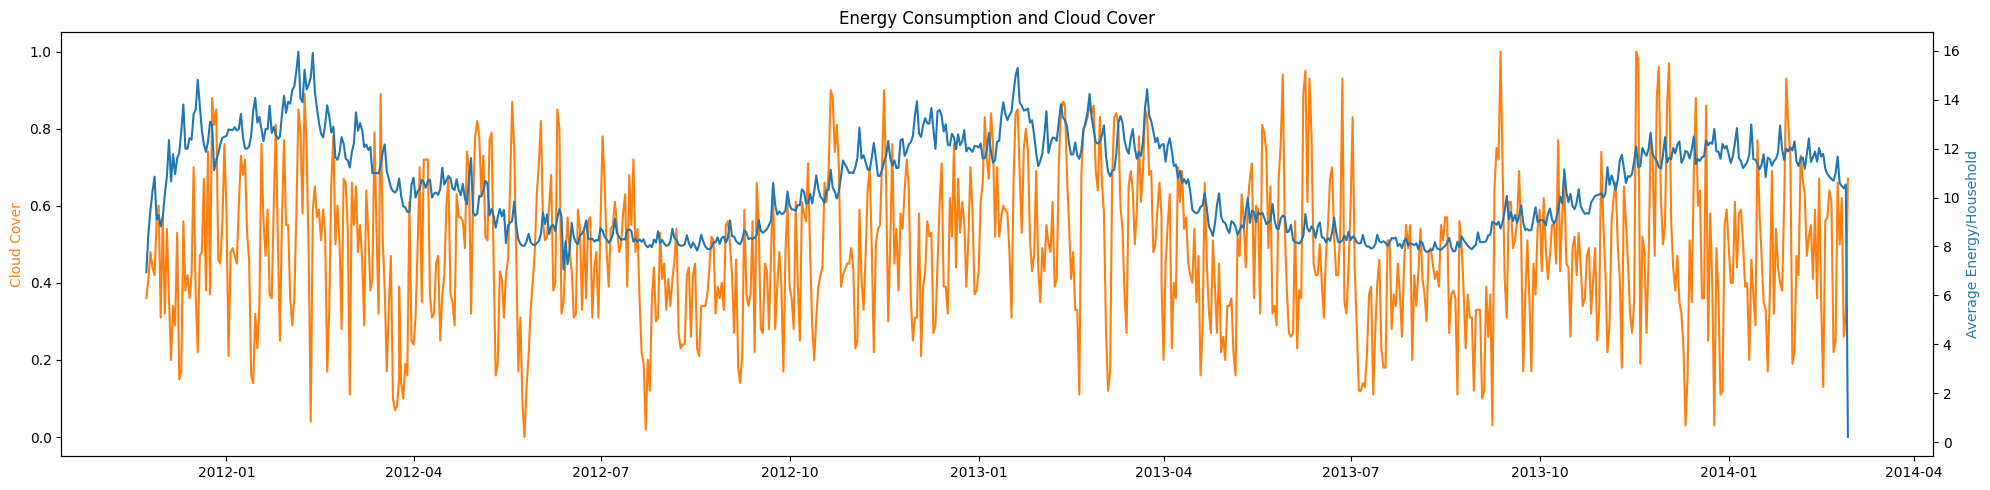

In [66]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

4. Visibility

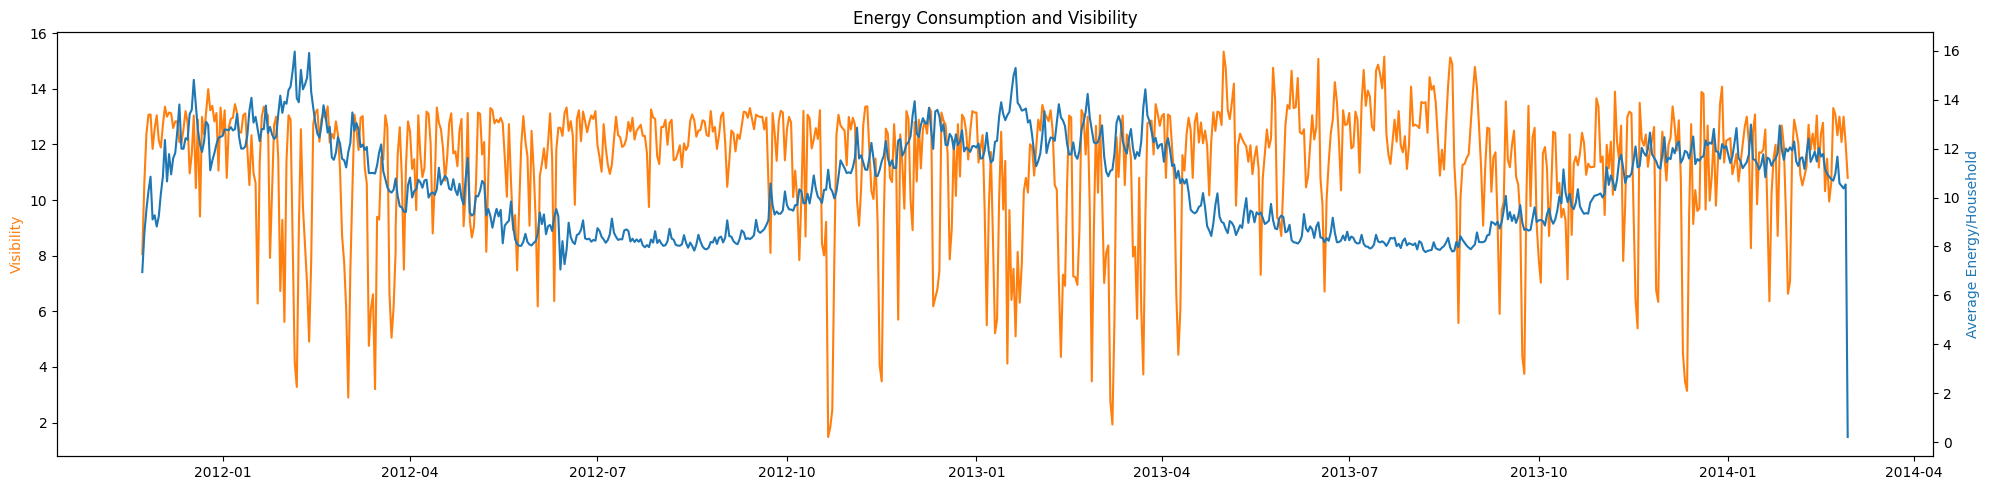

In [67]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

5. Wind Speed

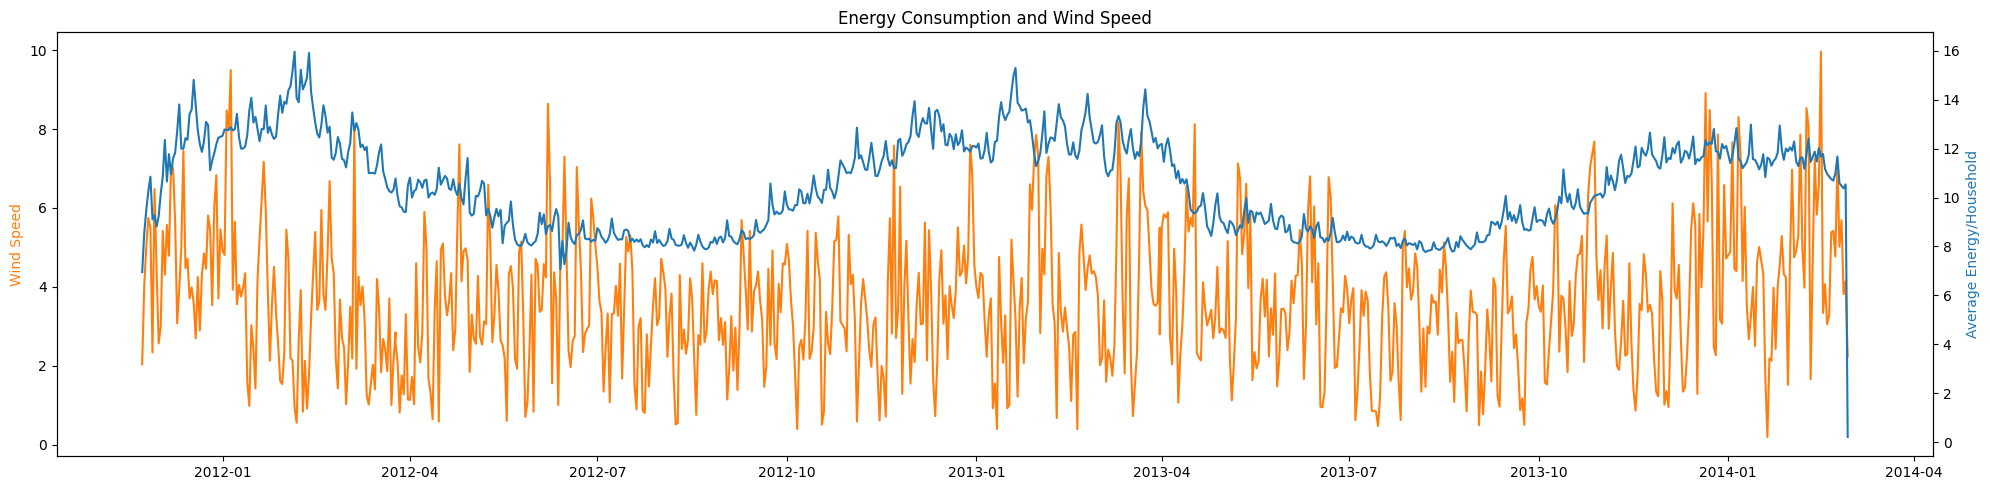

In [68]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

6. UV Index

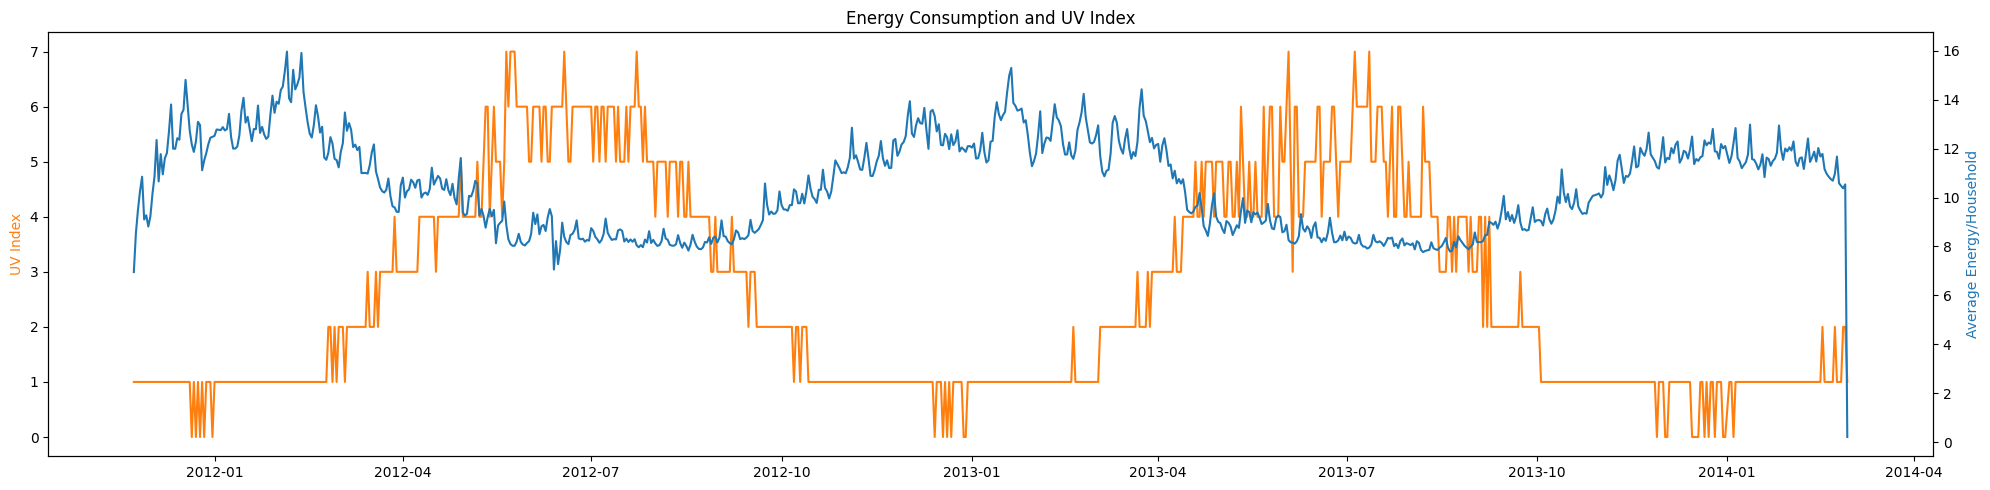

In [69]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

7. dewPoint

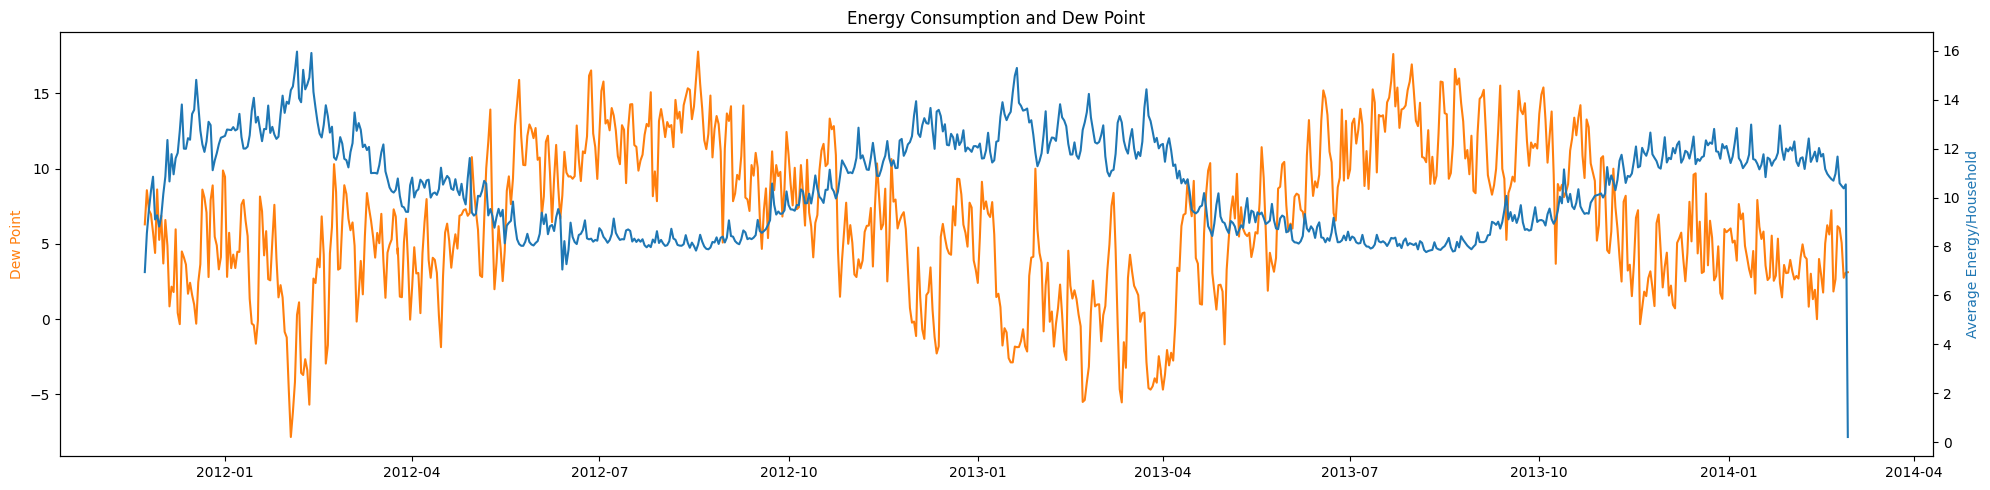

In [70]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

Correlation between Weather Variables and Energy Consumption
<!-- 
Energy has high positive correlation with humidity and high negative correlation with temperature.
Dew Point, UV Index display multicollinearity with Temperature, hence discarded
Cloud Cover and Visibility display multicollinearity with Humidity, hence discarded
Pressure and Moon Phase have minimal correlation with Energy, hence discarded
Wind Speed has low correlation with energy but does not show multicollinearity 
-->

In [71]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.846965,-0.755901,0.241779,0.149624,-0.028851,-0.246404,0.361237,-0.733171,-0.031716
temperatureMax,-0.846965,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.755901,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.241779,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.149624,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.028851,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.246404,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.361237,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.733171,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031716,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


Creating Weather Clusters

In [72]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

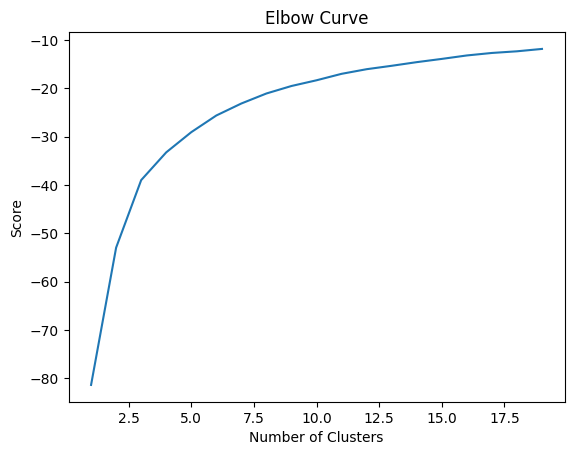

In [73]:
# optimum K
from sklearn.cluster import KMeans
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [74]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

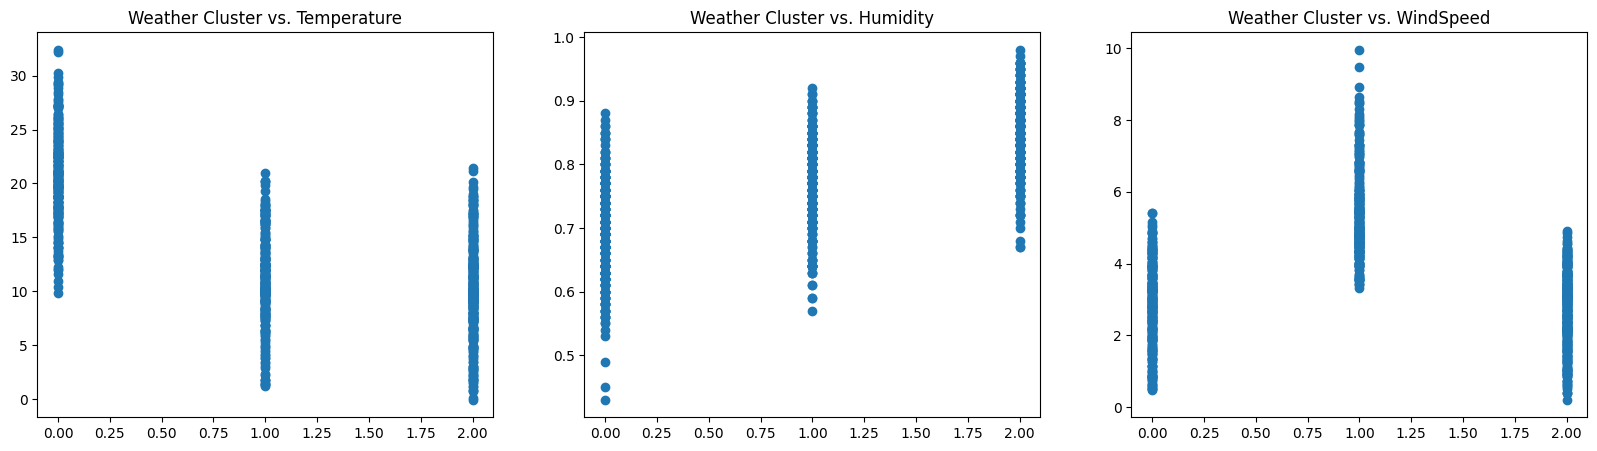

In [75]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()

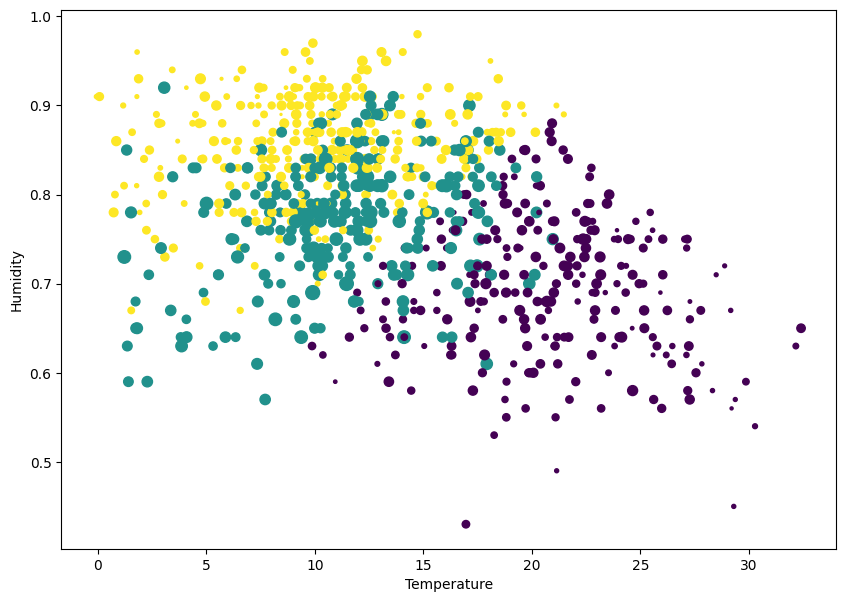

In [76]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, 
            weather_energy.humidity, 
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

UK Bank Holidays

In [77]:
holiday = pd.read_csv('C:/Users/diana/Desktop/proiect test/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)


Creating a holiday indicator on weather data

In [78]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

ARIMAX

In [79]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

Subset for required columns and 70-30 train-test split

In [80]:
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

<Axes: xlabel='day'>

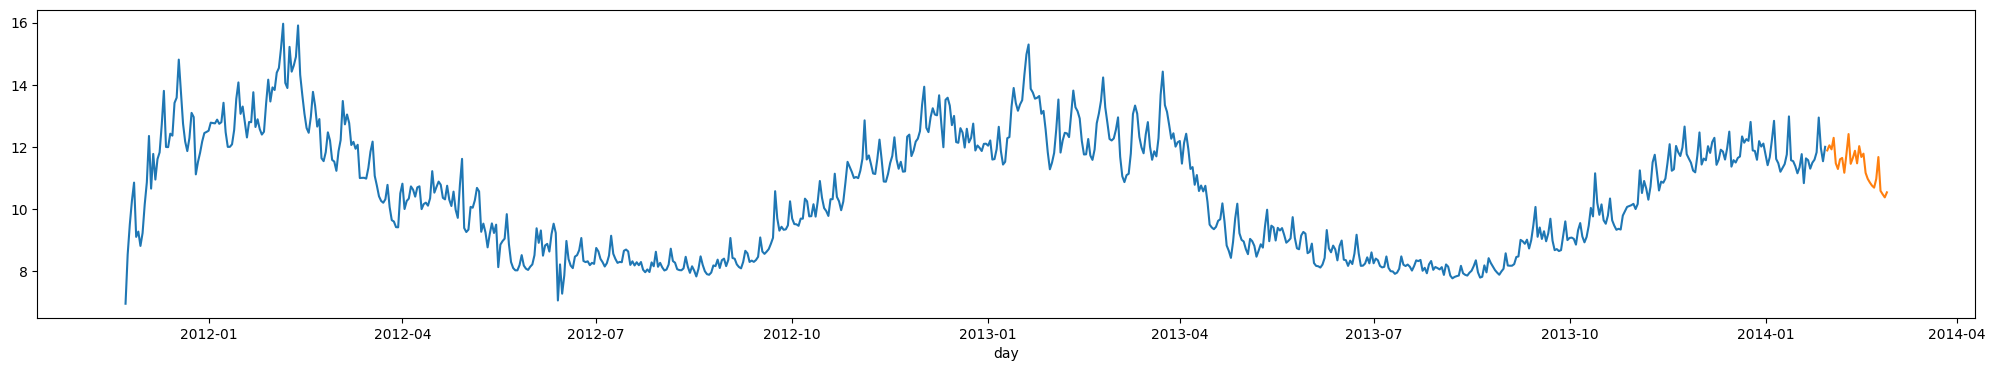

In [81]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))

In [82]:
test.head(1)

,avg_energy,weather_cluster,holiday_ind
day,,,
2014-01-30,11.886982,2,0


ACF PACF

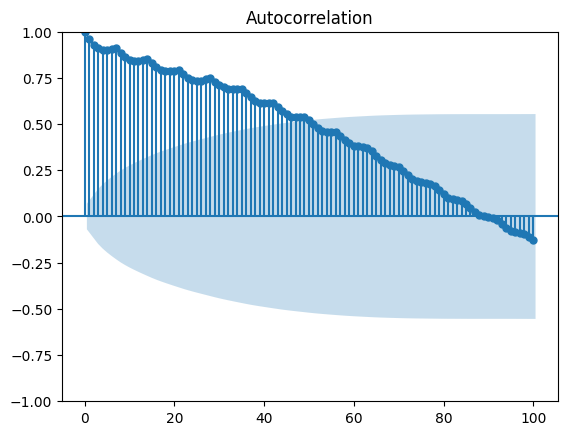

In [83]:
plot_acf(train.avg_energy,lags=100)
plt.show()

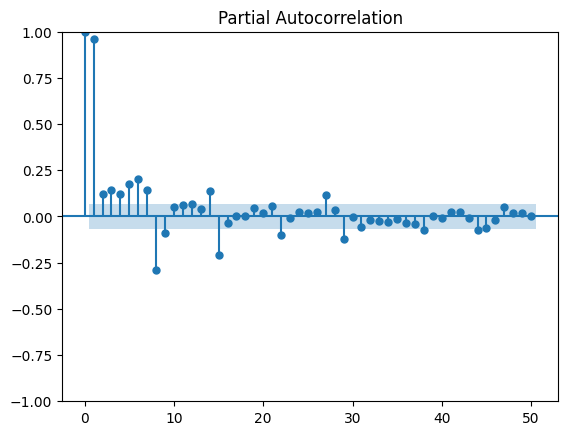

In [84]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

Dickey Fuller's Test

In [85]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.872794
p-value                          0.344966
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

In [86]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [87]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.715004e+00
p-value                        3.600554e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.760000e+02
dtype: float64

Seasonal Decomposition

In [88]:
s = sm.tsa.seasonal_decompose(train.avg_energy, period=12)

<Axes: xlabel='day'>

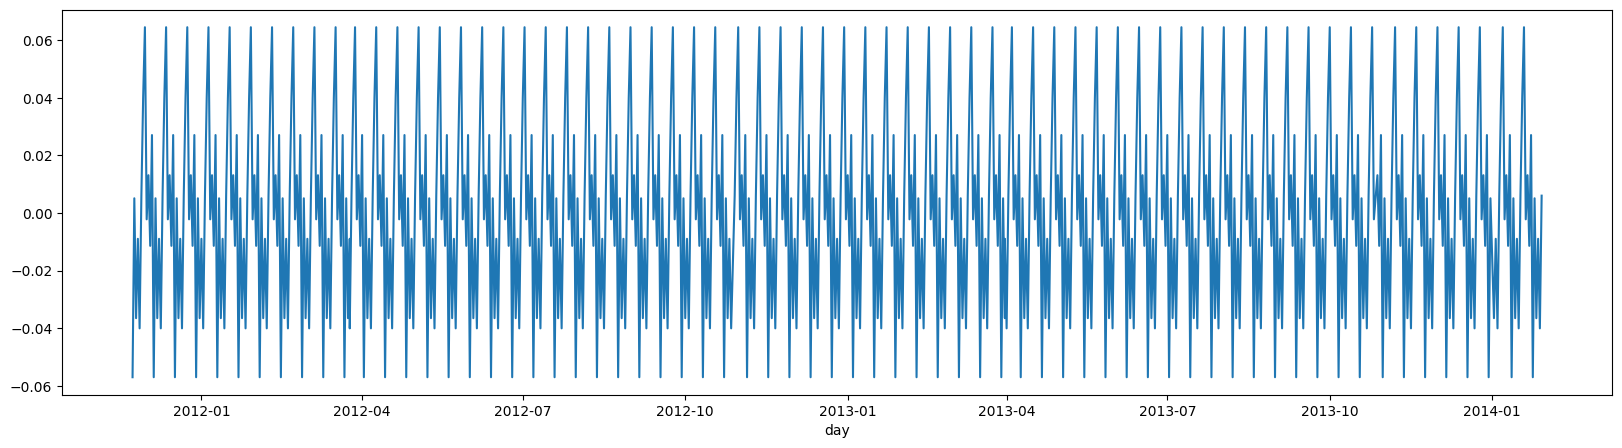

In [89]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='day'>

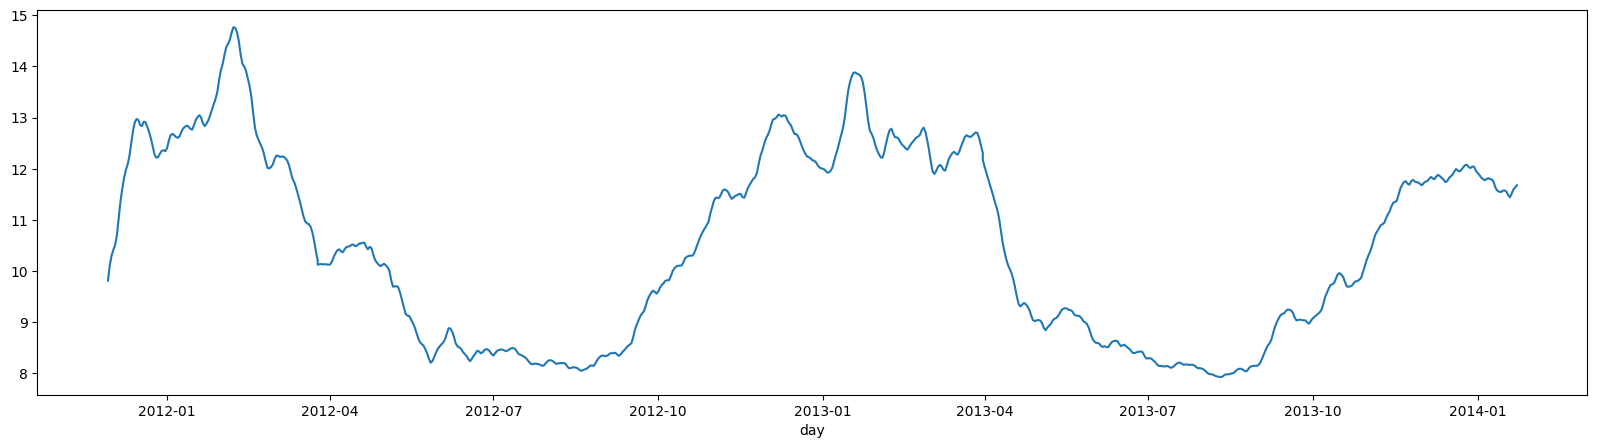

In [90]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='day'>

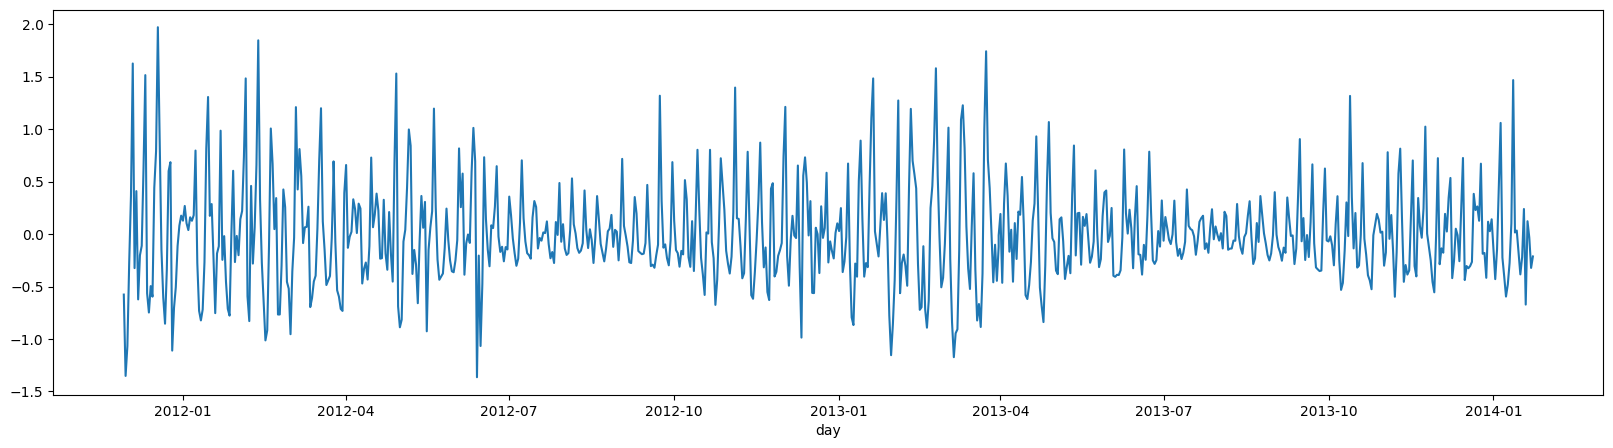

In [91]:
s.resid.plot(figsize=(20,5))

In [92]:
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7, 1, 1), seasonal_order=(1, 1, 0, 12))
model_fit = mod.fit()
model_fit.summary() # type: ignore

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -649.410
Date:                             Sat, 15 Jul 2023   AIC                           1324.820
Time:                                     17:20:26   BIC                           1385.474
Sample:                                          0   HQIC                          1348.142
                                             - 798                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -2.98e-08   3.78e+05  -7.87e-14      1.000   -7.42e+05    7.42e+05
weather_cluster     0.0100      0.024      0.411      0.681      -0.038       0.058
holiday_ind        -0.0357      0.088     -0.406      0.685      -0.208       0.137
ar.L1              -0.0013      0.086     -0.015      0.988      -0.170       0.168
ar.L2              -0.1537      0.032     -4.811      0.000      -0.216      -0.091
ar.L3              -0.1437      0.039     -3.688      0.000      -0.220      -0.067
ar.L4              -0.1512      0.038     -3.982      0.000      -0.226      -0.077
ar.L5              -0.1634      0.040     -4.112      0.000      -0.241      -0.086
ar.L6               0.0090      0.036      0.246      0.805      -0.062       0.080
ar.L7               0.3524      0.029     12.293      0.000       0.296       0.409
ma.L1              -0.1871      0.091     -2.050      0.040      -0.366      -0.008
ar.S.L12           -0.4843      0.033    -14.855      0.000      -0.548      -0.420
sigma2              0.3041      0.013     23.855      0.000       0.279       0.329
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                45.34
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.7e+14. Standard errors may be unstable.
"""

Model fit

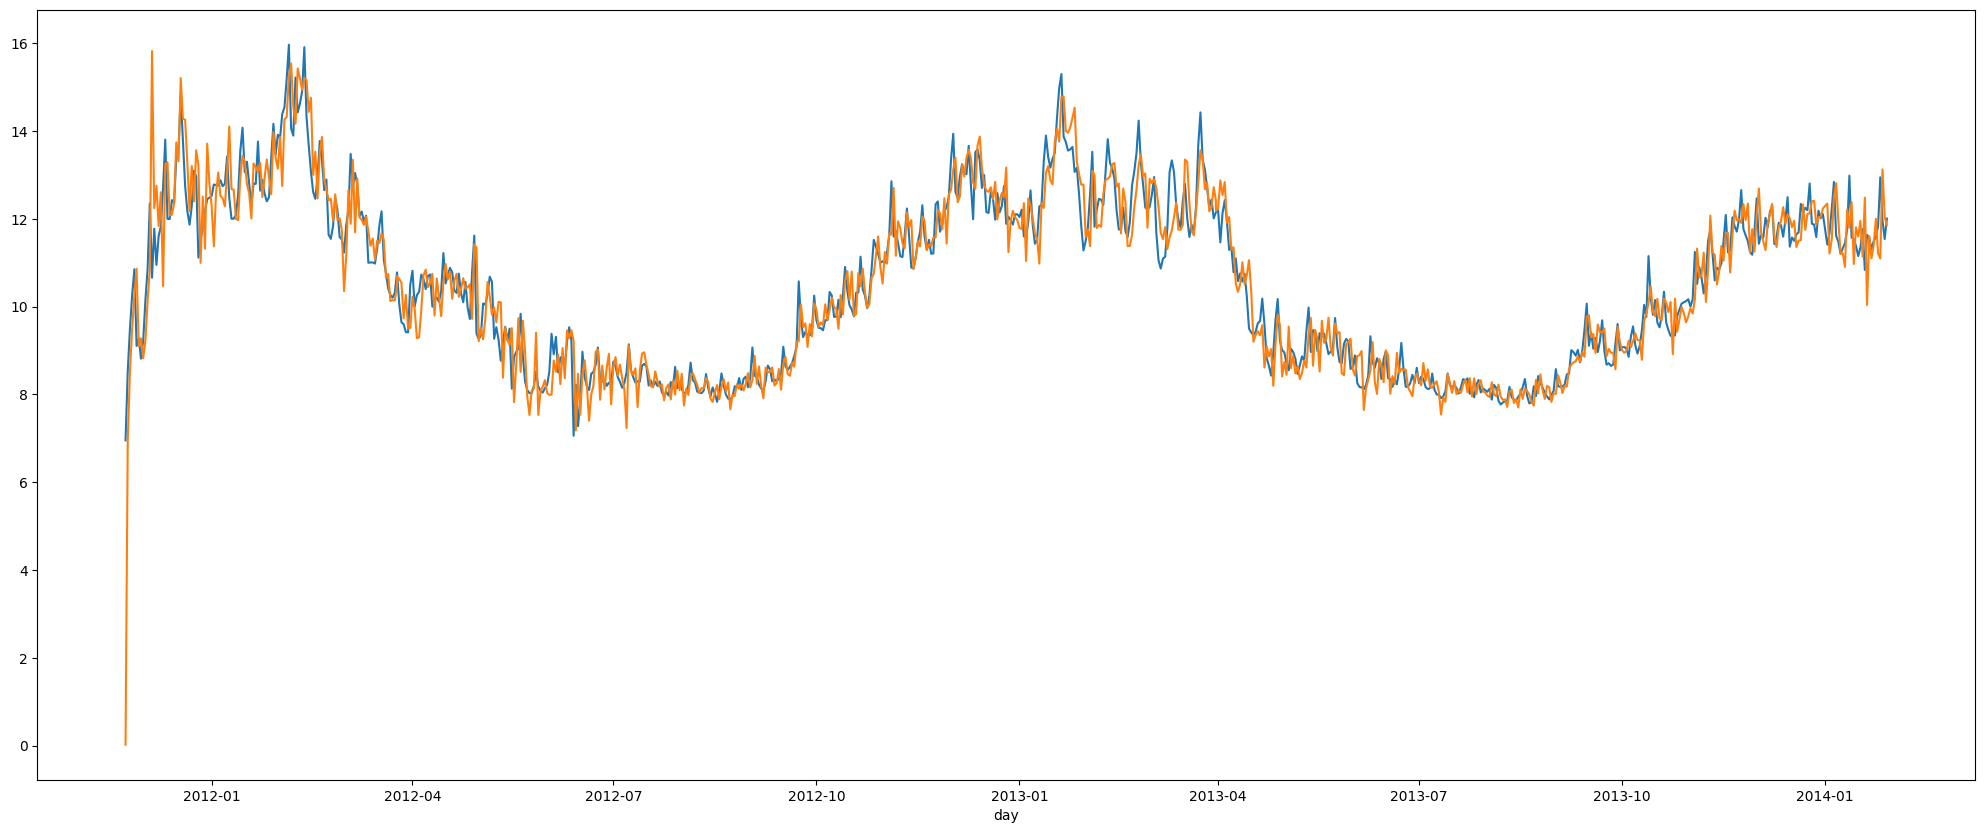

In [93]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot() # type: ignore
plt.show()

Model Prediction

In [95]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster','holiday_ind']])) # type: ignore
test.loc[:, 'predicted'] = predict.values
test.tail(5)

,avg_energy,weather_cluster,holiday_ind,predicted
day,,,,
2014-02-23,11.673756,1,0,11.715627
2014-02-24,10.586235,1,0,10.872328
2014-02-25,10.476498,1,0,11.617997
2014-02-26,10.375366,1,0,12.059194
2014-02-27,10.537250,1,0,11.681719


In [96]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.6277314185036414
MAPE: 5.645435252250478


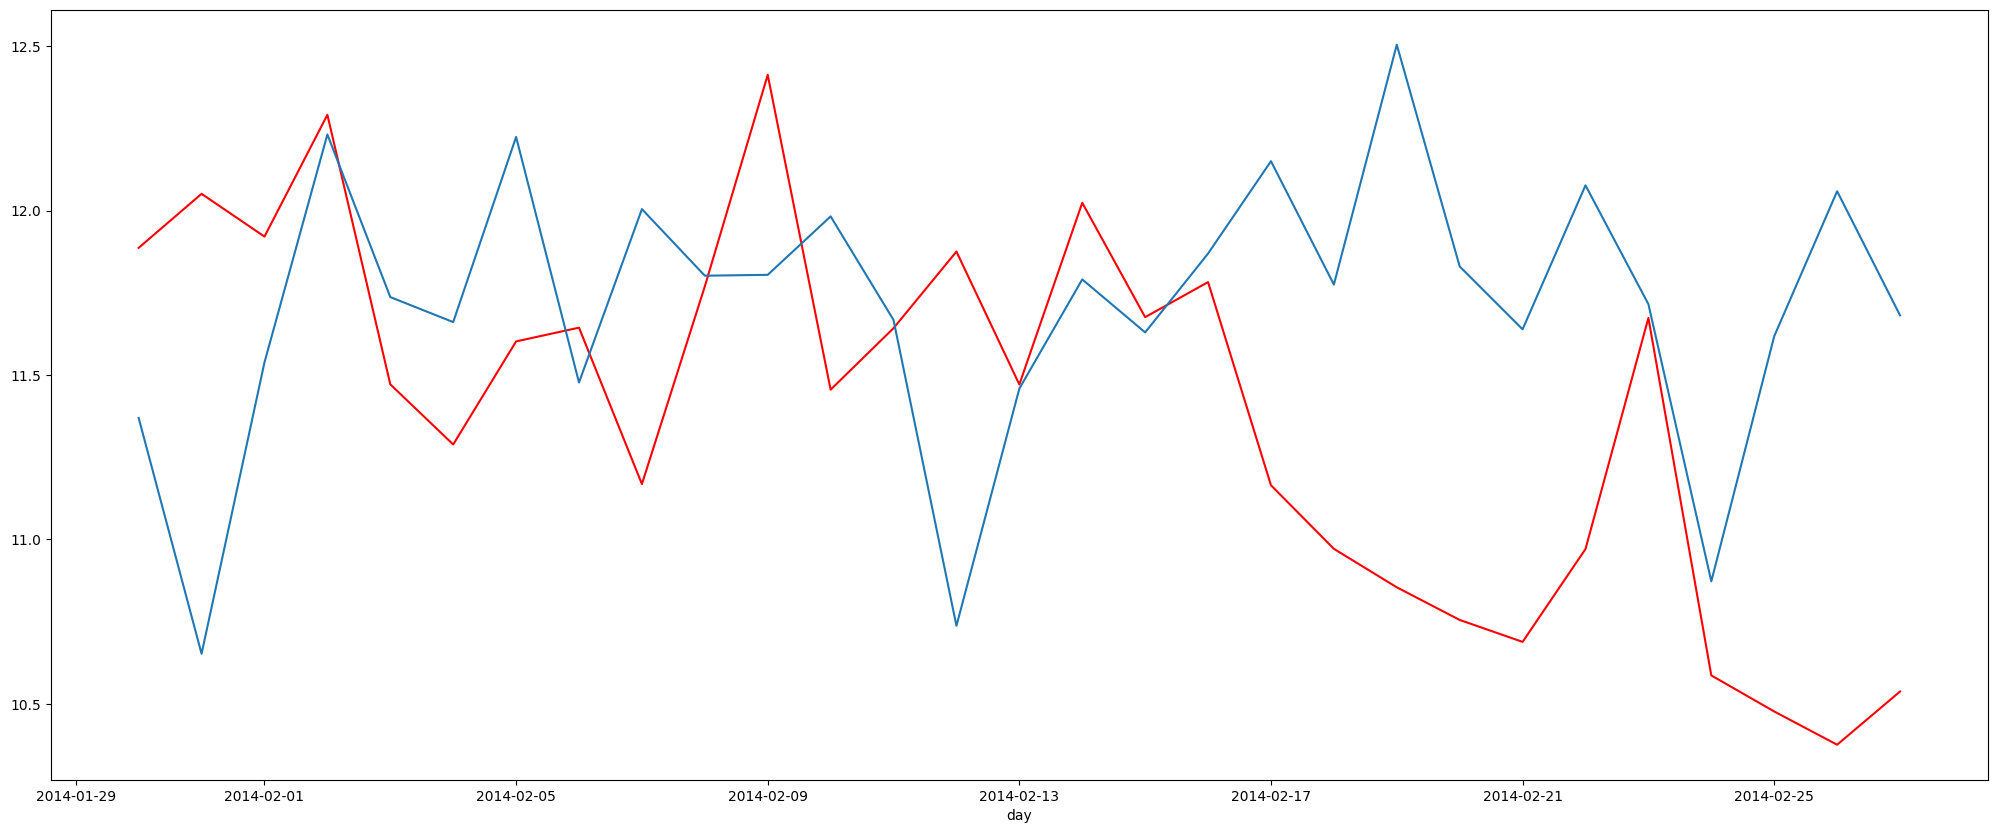

In [97]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

<Axes: xlabel='day'>

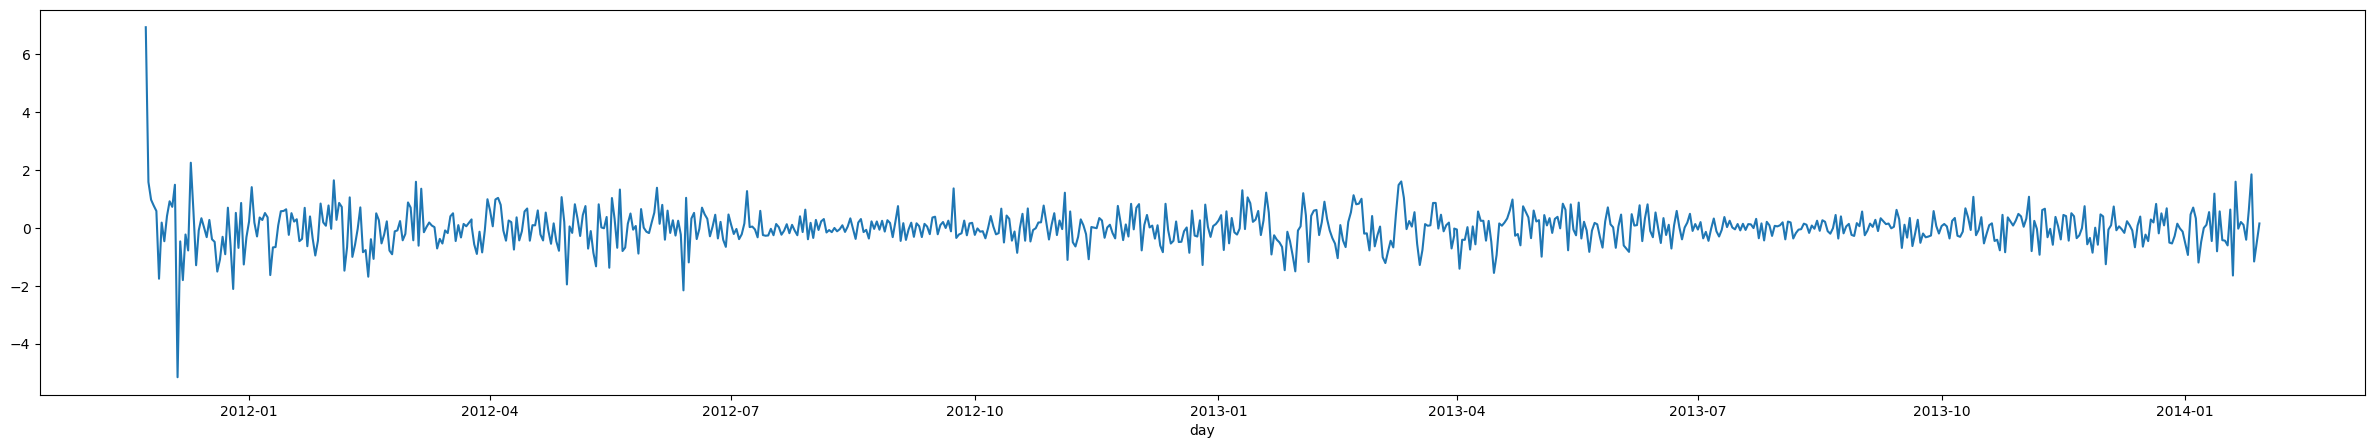

In [100]:
model_fit.resid.plot(figsize= (30,5)) # type: ignore

<Axes: xlabel='day'>

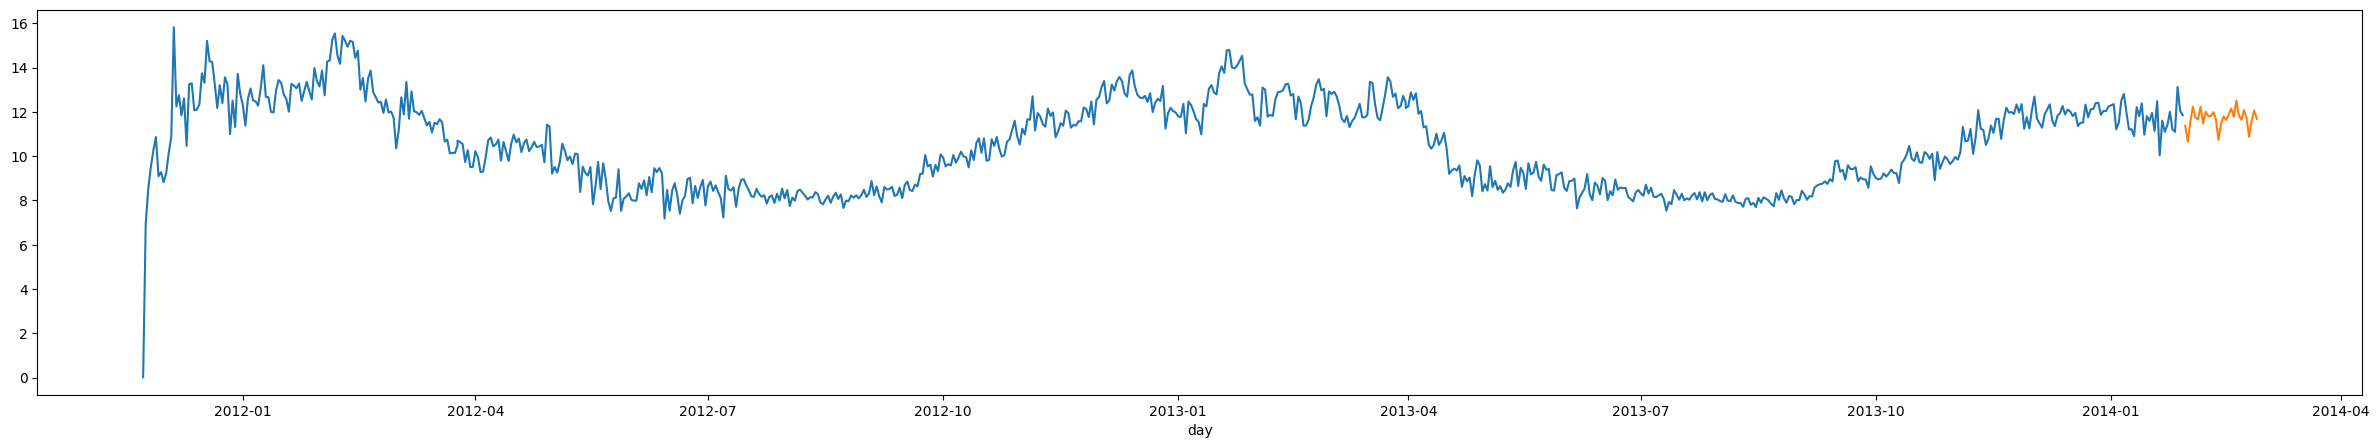

In [101]:
model_fit.fittedvalues.plot(figsize = (30,5)) # type: ignore
test.predicted.plot()

In [102]:
test['predicted'].tail(5)

day
2014-02-23    11.715627
2014-02-24    10.872328
2014-02-25    11.617997
2014-02-26    12.059194
2014-02-27    11.681719
Name: predicted, dtype: float64

LSTM

In [103]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [104]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [105]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


In [106]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]

In [107]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

Normalization

In [108]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [109]:
# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]

In [110]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [111]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(791, 1, 9) (791,) (30, 1, 9) (30,)


Modelling

Epoch 1/50
11/11 - 5s - loss: 0.6060 - 5s/epoch - 449ms/step
Epoch 2/50
11/11 - 0s - loss: 0.4783 - 66ms/epoch - 6ms/step
Epoch 3/50
11/11 - 0s - loss: 0.3360 - 81ms/epoch - 7ms/step
Epoch 4/50
11/11 - 0s - loss: 0.1769 - 79ms/epoch - 7ms/step
Epoch 5/50
11/11 - 0s - loss: 0.1279 - 69ms/epoch - 6ms/step
Epoch 6/50
11/11 - 0s - loss: 0.1261 - 56ms/epoch - 5ms/step
Epoch 7/50
11/11 - 0s - loss: 0.1110 - 61ms/epoch - 6ms/step
Epoch 8/50
11/11 - 0s - loss: 0.1021 - 61ms/epoch - 6ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0939 - 70ms/epoch - 6ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0866 - 81ms/epoch - 7ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0791 - 59ms/epoch - 5ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0717 - 68ms/epoch - 6ms/step
Epoch 13/50
11/11 - 0s - loss: 0.0644 - 67ms/epoch - 6ms/step
Epoch 14/50
11/11 - 0s - loss: 0.0577 - 64ms/epoch - 6ms/step
Epoch 15/50
11/11 - 0s - loss: 0.0511 - 81ms/epoch - 7ms/step
Epoch 16/50
11/11 - 0s - loss: 0.0451 - 62ms/epoch - 6ms/step
Epoch 17/50
11/11

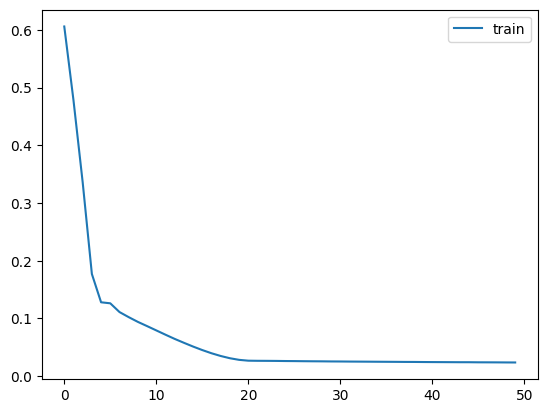

In [113]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False) # type: ignore
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

Prediction

In [115]:
# make a prediction
yhat = model.predict(test_X)

1/1 [==============================] - 1s 1s/step


In [116]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [117]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [118]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

Performance

In [119]:
act = [i[9] for i in inv_y] # last element is the predicted average energy
pred = [i[9] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


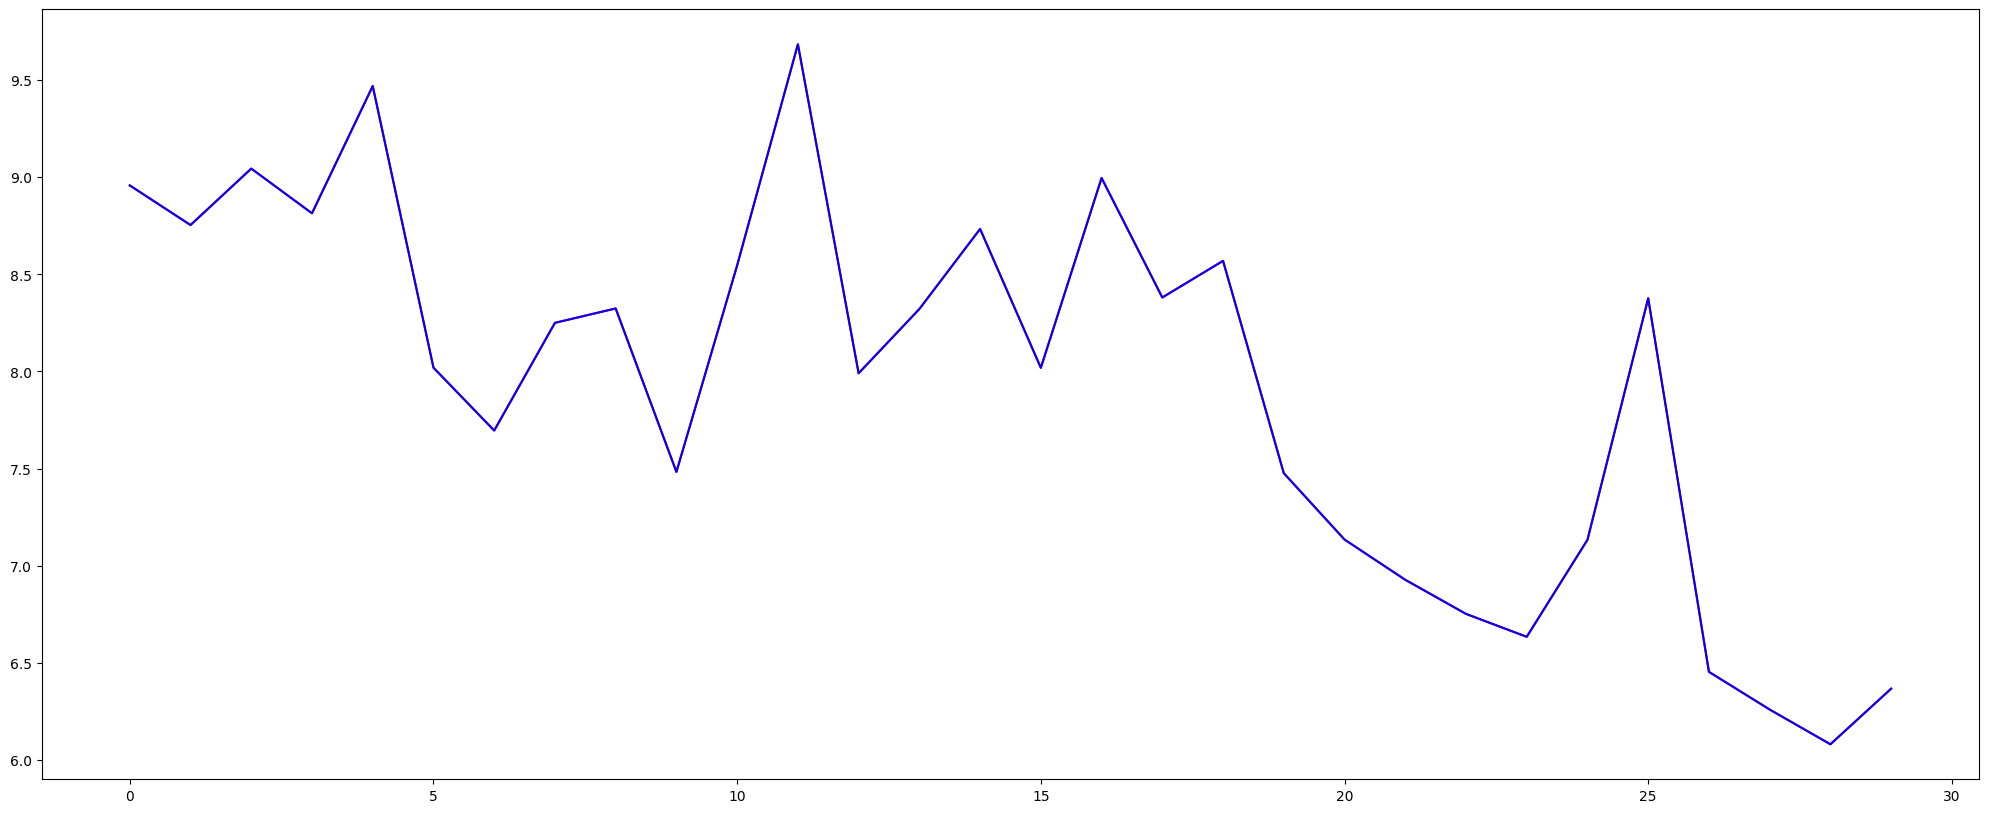

In [120]:
predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()